In [26]:
import numpy as np 

import jax
import jax.numpy as jnp 
from jax import lax


import matplotlib.pyplot as plt

import scipy
from scipy.special import legendre
from scipy.special import spherical_jn 

import sys
import os
from functools import partial

jax.config.update("jax_platform_name", "cpu")

# plt.style.use('ggplot')
jax.default_backend()   

plt.rcParams.update({
    "axes.grid": True,
    "grid.alpha": 0.5
})


### Spherical Bessel functions

In this notebook I write efficient and stable Jax code to implement Spherical Bessel functions using recurrence relation and relation to Bessel function of first kind.

In [93]:
from jax import lax

def _leggauss(K: int):
    # Static host-side nodes/weights; OK for JIT since shape is static.
    X, w = np.polynomial.legendre.leggauss(K)
    return jnp.asarray(X, dtype=jnp.float64), jnp.asarray(w, dtype=jnp.float64)

def _spherical_jn_all(x: jnp.ndarray, n_max: int):
    """
    Compute j_n(x) for n=0..n_max on a whole grid x (broadcasted),
    using the 3-term recurrence:
      j_{n+1}(x) = (2n+1)/x * j_n(x) - j_{n-1}(x)
    Returns array with shape (n_max+1, *x.shape).

    NOTE: This implementation is suitable for when x > n. 
    """
    x = x.astype(jnp.float64)
    # Safe divisions at x=0 using limits
    def safe_div(num, den):
        return jnp.where(den == 0.0, 0.0, num / den)

    j0 = jnp.where(x == 0.0, 1.0, jnp.sin(x) / x)
    j1 = jnp.where(x == 0.0, 0.0, jnp.sin(x) / (x * x) - jnp.cos(x) / x)

    if n_max == 0:
        return j0[None, ...]
    if n_max == 1:
        return jnp.stack([j0, j1], axis=0)

    def body(carry, k):
        jm1, jn = carry  # j_{k-1}, j_k
        coef = (2 * k + 1.0) * safe_div(1.0, x)
        jp1 = coef * jn - jm1
        return (jn, jp1), jp1

    (_, _,), ys = lax.scan(body, (j0, j1), jnp.arange(1, n_max))
    # ys holds j2..j_{n_max}
    return jnp.concatenate([j0[None, ...], j1[None, ...], ys], axis=0)


In [4]:
X,w = scipy.special.roots_legendre(150)
X_scaled = 0.5*X + 0.5

jn_approx = _spherical_jn_all(X_scaled, 10)

In [5]:
from scipy.special import spherical_jn 

jn_true = []
for k in range(10):
    jn_true.append(spherical_jn(k,X_scaled))

jn_true = np.array(jn_true)

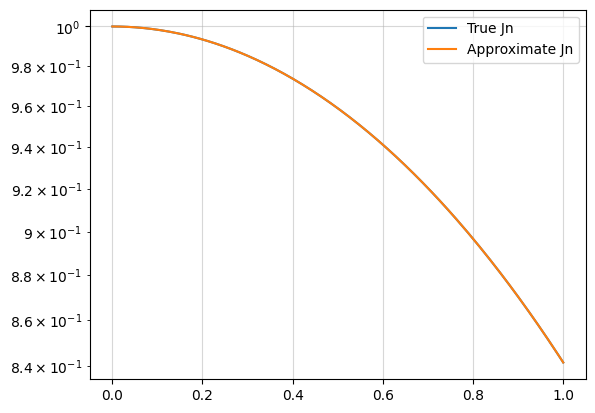

In [11]:
plt.plot(X_scaled,jn_true[0,:],label="True Jn")
plt.plot(X_scaled,jn_approx[0,:], label="Approximate Jn")
plt.yscale('log')
plt.legend();

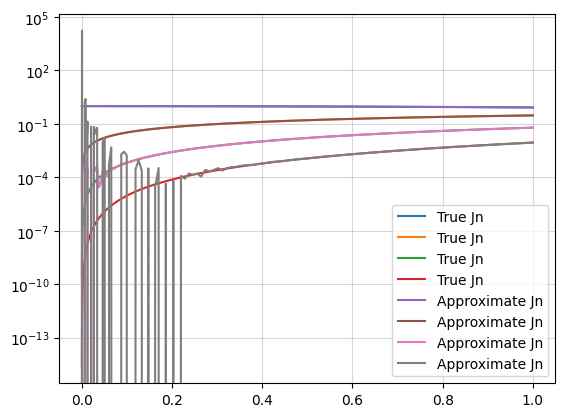

In [9]:
plt.plot(X_scaled,jn_true[:4,:].T,label="True Jn")
plt.plot(X_scaled,jn_approx[:4,:].T, label="Approximate Jn")
plt.yscale('log')
plt.legend();

For higher orders we get higher orders on smaller scale. To try to fix this we use the relation:

$$ j_n(z) = \sqrt{\frac{\pi}{2z}} J_{n+1/2}(z)$$

To evaluate the Bessel function we use it's power series and calculate the coefficients of the series in a recursive order.

In [31]:
def jv_small(nu, x, max_terms=100, tol=1e-15):
    """
    Cylindrical Bessel J_nu(x) for small |x| via power series.
    Works with scalar or array x, broadcasts over nu/x.

    args:
        nu: Cylindrical Bessel order 
        x: array input 
        max_terms: max numbers of terms to truncate the power series 
        tol: error tolerence
    """
    x = jnp.asarray(x)
    nu = jnp.asarray(nu)
    # a0 = (x/2)^nu / Gamma(nu+1); compute in log-space for stability
    log_a0 = nu * (jnp.log(jnp.abs(x)) - jnp.log(2.0)) - jax.lax.lgamma(nu + 1.0)
    a0 = jnp.exp(log_a0)
    # carry the sign of x^nu if x<0 and nu non-integer (we’ll assume real x, nu)
    # For real-valued principal branch, (x/2)^nu = exp(nu*log|x/2|) with no extra sign.

    z = (x * 0.5)**2

    def body(carry, k):
        """ Computes the Bessel power function efficiently by computing the
            ratio a_{k+1}/a_k.
        """
        term, s, done = carry
        # accumulate where not converged
        s = jnp.where(done, s, s + term)
        # next term via ratio
        denom = (k + 1.0) * (k + nu + 1.0)
        next_term = term * (-z) / denom
        # convergence check (relative to current sum)
        done_next = done | (jnp.abs(next_term) <= tol * (1.0 + jnp.abs(s)))
        return (next_term, s, done_next), None

    # initialize
    carry0 = (a0, jnp.zeros_like(a0), jnp.zeros_like(a0, dtype=bool))
    (termN, sumN, doneN), _ = jax.lax.scan(body, carry0, jnp.arange(max_terms))

    # Add the last term (scan adds term before updating; we added inside body already)
    out = sumN

    # Handle x=0 explicitly:
    # J_0(0)=1; J_nu(0)=0 for nu>0 (for Re(nu)>-1). We’ll set J_nu(0)=0 unless nu==0.
    out = jnp.where(x == 0,
                    jnp.where(nu == 0, jnp.ones_like(out), jnp.zeros_like(out)),
                    out)
    return out


@partial(jax.vmap, in_axes=(0,None))
def jn_spherical_small(nu, z, max_terms=100, tol=1e-15):
    return jnp.sqrt(jnp.pi/(2.0*z)) * jv_small(nu+0.5, z, max_terms, tol)

/tmp/ipykernel_2205021/3211508400.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();


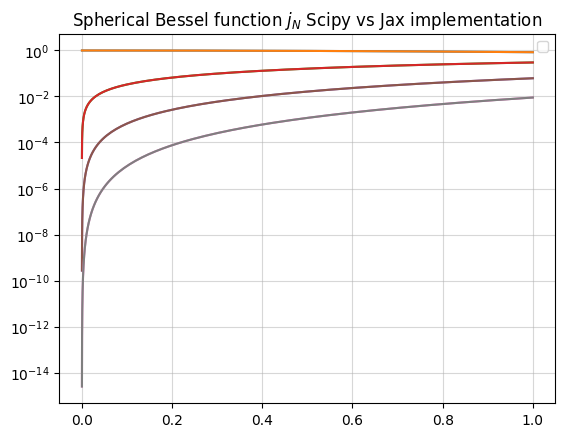

In [80]:
jn_small_approx = jn_spherical_small(jnp.arange(10),X_scaled)

plt.title(r"Spherical Bessel function $j_N$ Scipy vs Jax implementation")
for k in range(4):
    plt.plot(X_scaled,jn_true[k])
    plt.plot(X_scaled,jn_small_approx[k])
plt.yscale('log')
plt.legend();

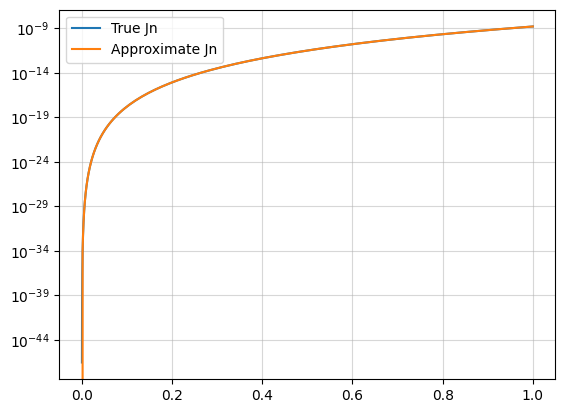

In [82]:
plt.plot(X_scaled,jn_true[9,:],label="True Jn")
plt.plot(X_scaled,jn_small_approx[9,:], label="Approximate Jn")
plt.yscale('log')
plt.legend();

In [87]:
jn_true = []
for k in range(30):
    jn_true.append(spherical_jn(k,X_scaled))

jn_true = np.array(jn_true)

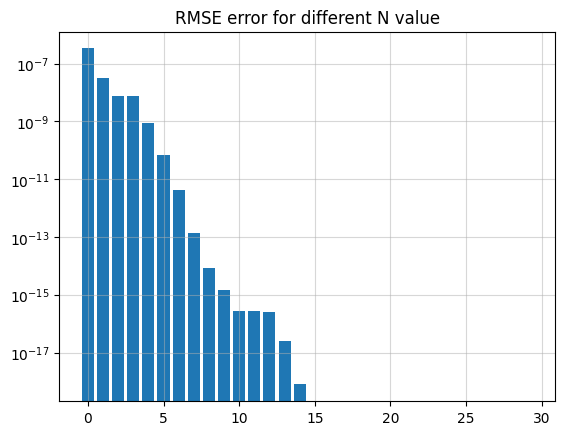

In [94]:
jn_small_approx = jn_spherical_small(jnp.arange(30),X_scaled)

rmses = jnp.sqrt(jnp.mean((jn_true - jn_small_approx)**2,axis=1))
plt.bar(x=np.arange(30),height=rmses)
plt.yscale('log')
plt.title("RMSE error for different N value");

### Optimized Fredholm Integral equation solver

In [170]:
from kltpicker_3d.alt_least_squares import alternating_least_squares_solver
from kltpicker_3d.tests.exp_spectrum import *
from kltpicker_3d.tests.gaussian_spectrum import * 
from kltpicker_3d.tests.rpsd_test_data import generate_gaussian_rpsd_data
from kltpicker_3d.tomogram import factorize_RPSD
from kltpicker_3d.utils import * 

vect_spectrum_estimation = jax.vmap(estimate_isotropic_powerspectrum_tensor,
                                    in_axes=(0,None))

uniform_points, bins = generate_uniform_radial_sampling_points(N)
max_d = int(np.floor(N/3))                                      

In [198]:
K = 100
N = 32 
M = 2*N - 1 

                                                      
grid = np.arange(-(N-1),N)
i,j,k  = np.meshgrid(grid,grid,grid)
omega_r = np.sqrt(i**2 + j**2 + k**2)
T = -np.log(1e-15)/120
H = np.exp(-T*omega_r)
C = M ** 3 / H.sum()
normalized_H = np.fft.ifftshift(np.sqrt(H * C))

samples = np.zeros((K,N,N,N))
alphas = np.random.beta(2,5,size=(K)) 
for k in range(K):
    noise = np.random.normal(size=(M,M,M))
    additive_noise = np.random.normal(scale=0.1,size=(M,M,M))
    sample = np.fft.ifftn(normalized_H*np.fft.fftn(noise))
    sample = alphas[k]*sample + additive_noise
    samples[k] = sample[:N,:N,:N]

samples = samples.real 

/tmp/ipykernel_2205021/2632217799.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  samples[k] = sample[:N,:N,:N]


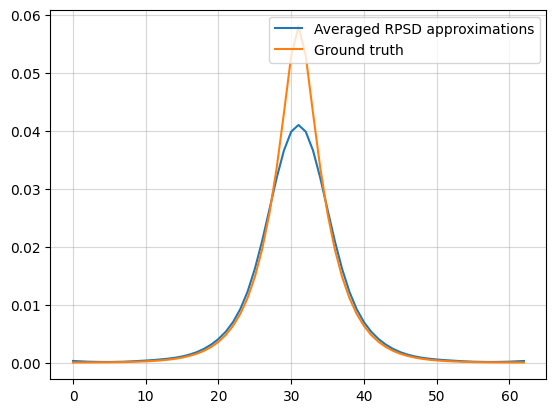

In [199]:
samples = samples - jnp.mean(samples, axis=(1,2,3)).reshape(-1,1,1,1)
psd = vect_spectrum_estimation(samples,max_d)  

S = H / np.linalg.norm(H)
avg_psd = np.mean(psd,axis=0)
avg_psd /= np.linalg.norm(avg_psd)

plt.plot(avg_psd[N,N,:], label='Averaged RPSD approximations')
plt.plot(S[N,N,:], label='Ground truth')
plt.legend();

In [200]:
def trigonometric_interpolation(x,y,z):
    n = x.shape[0]
    
    scale = (x[1] - x[0]) * n / 2 
    x_scaled = (x / scale) * jnp.pi / 2 
    z_scaled = (z / scale) * jnp.pi / 2

    delta = z_scaled[:, None] - x_scaled[None, :]
    # We take n to be only even 
    M = jnp.sin(n*delta) / (n *jnp.sin(delta))
    #if n % 2 == 0:
    #    M = np.sin(n*delta) / (n *jnp.sin(delta))
    #else:
    #    M = np.sin(n*delta)/ (n*jnp.tan(delta))
    M = M.at[jnp.isclose(delta,0)].set(1.0)

    p = M @ y 
    return p

X,w = scipy.special.roots_legendre(150)
X_scaled = 0.5*X + 0.5

In [201]:
rblocks = np.array([radial_average(psd[k], bins, N) for k in range(K)])
factorization = alternating_least_squares_solver(rblocks,500,1e-4)

/tmp/ipykernel_2205021/2355446449.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1,0].legend()


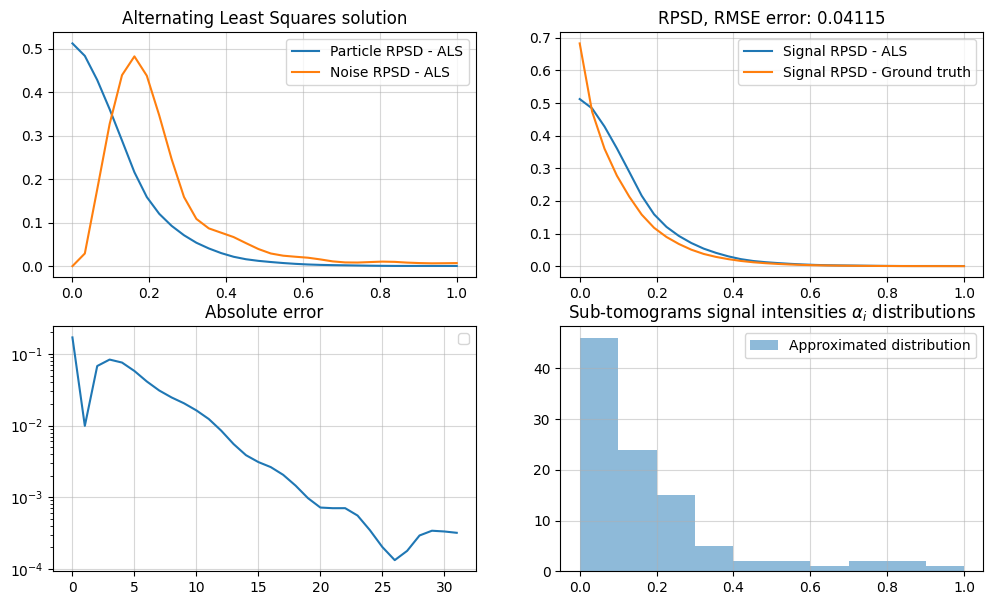

In [202]:
particle_psd = factorization.gamma
noise_psd = factorization.v

noise_psd /= np.linalg.norm(noise_psd)
particle_psd /= np.linalg.norm(particle_psd)


fig, ax = plt.subplots(2,2, figsize=(12,7))

extracted_alphas = factorization.alpha

H /= np.linalg.norm(H)

true_rpsd = radial_average(H,bins,N)
true_rpsd /= np.linalg.norm(true_rpsd)

ax[0,0].plot(uniform_points,particle_psd, label='Particle RPSD - ALS')
ax[0,0].plot(uniform_points,noise_psd, label='Noise RPSD - ALS')
ax[0,0].set_title("Alternating Least Squares solution")
ax[0,0].legend()


ax[0,1].plot(uniform_points,particle_psd,label='Signal RPSD - ALS')
ax[0,1].plot(uniform_points,true_rpsd, label='Signal RPSD - Ground truth')
#ax[0,1].set_yscale('log')
ax[0,1].set_title("RPSD benchmark")
ax[0,1].set_title(f"RPSD, RMSE error: {np.sqrt(np.mean((true_rpsd - particle_psd)**2)):.5f}")
ax[0,1].legend()

ax[1,0].set_title("Absolute error")
ax[1,0].plot(np.abs(true_rpsd - particle_psd))
ax[1,0].set_yscale('log')
ax[1,0].legend()

ax[1,1].set_title(r"Sub-tomograms signal intensities $ \alpha_i$ distributions")
ax[1,1].hist(extracted_alphas,alpha=0.5, label='Approximated distribution')
ax[1,1].legend();

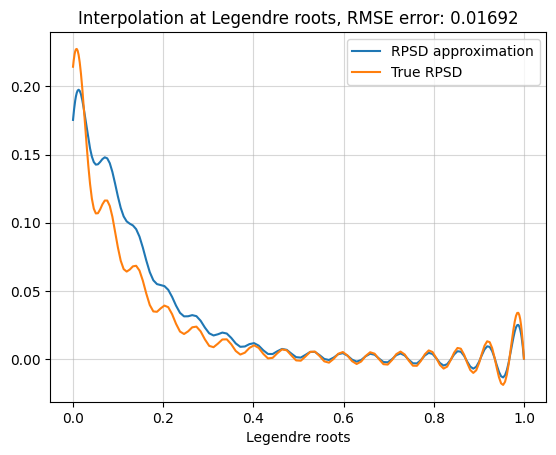

In [203]:
particle_psd = factorization.gamma
X,w = scipy.special.roots_legendre(150)
X_scaled = 0.5*X + 0.5
Gx = trigonometric_interpolation(uniform_points, particle_psd, X_scaled)
Gx /= np.linalg.norm(Gx)
Gx_true = trigonometric_interpolation(uniform_points, true_rpsd, X_scaled)
Gx_true /= np.linalg.norm(Gx_true)
plt.title("RPSD interpolation")
plt.plot(X_scaled, Gx, label='RPSD approximation')
plt.plot(X_scaled, Gx_true, label='True RPSD')
plt.title(f"Interpolation at Legendre roots, RMSE error: {np.sqrt(np.mean((Gx_true - Gx)**2)):.5f}")
plt.xlabel("Legendre roots")
plt.legend();

In [ ]:
a,c = 1,-np.log(1e-15)/T

In [ ]:
legendre_roots, w = scipy.special.roots_legendre(K)
legendre_roots,w = jnp.array(legendre_roots), jnp.array(w)


rho_c = c/2 * legendre_roots + c/2 # Psi_n integral var 
rho_a = a/2 * legendre_roots + a/2 # Outer variable 

# NxK matrix containing Legendre polynomial over [-1,1] 
# for orders up to N
p = jnp.array([legendre(k)(legendre_roots) for k in range(N)])

# Grid input for H_N
Hn_mat_input = rho_c[...,None]*rho_a[None,...]
   
even_orders = jnp.arange(2,N,2)
odd_orders = jnp.arange(1,N,2)

p_even = p[even_orders]
p_odd = p[odd_orders]

# Tensors of size N//2 x K x K 
hn_even = batched_Hn_even(special_fn_input,w,p_even) 
hn_odd = batched_Hn_odd(special_fn_input,w,p_odd)

hn = jnp.zeros((N,K,K))
hn = hn.at[even_orders].set(hn_even)
hn = hn.at[odd_orders].set(hn_odd)

vv = einsum("bij,bjl->bil", hn, jnp.matrix_transpose(hn))
jacobian = einsum("i,j->ij",r,rho) ** 2

batched_psi_matrix = einsum("k,bij,k,ik->bij",w,vv,G,jacobian)
   
# As of now there's no GPU-supported eigendecomposition
# However as we are dealing with relatively small matrices the CPU
# version is quite fast + the compilation help reduces time 
# signifincatly for calls after the first one
cpu_device = jax.devices('cpu')[0]
cpu_psi = jax.device_put(batched_psi_matrix,device=cpu_device)
eigenvalues, eigenfunctions = batched_eigdecomposition(cpu_psi,N)